# Jun 6th, 2022 (results so far, prune, mg)

**Motivation**: GABAN 512 <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from model.configuration import Config
from model.mouse import Mice
from analysis.group import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Prepare

In [2]:
mice = Mice(512)

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

In [3]:
task = 'rest'
b = (0.01, 0.5)
mice.setup_func_data(task, band_ca=b)

num_k, p = None, 20
perc = f'p{p}-sample'
props_base = {
    'kw_kmeans': {'n_init': 100},
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': task,
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

### Ca2

In [4]:
%%time

pi_avg = {}
pi_all = {}
for kk in tqdm(list(range(6, 15)) + [16, 20]):
    props_ca['num_k'] = kk
    gr_ca = Group(**props_ca).fit_group()
    pi_ca = gr_ca.prune(thres=0.003, ci=0.95)['pi_prune']
    pi_all[kk] = pi_ca
    pi_avg[f'ca2-k{kk}(pr95)\nb={b}'.replace(' ', '')] = avg(pi_ca)
    
# sort
d2p = pi_avg.copy()
for i in range(len(pi_avg)):
    lbl, x = list(pi_avg.items())[i]
    if i == 0:
        continue
    src = list(d2p.values())[i - 1]
    gmap = find_best_mappings(
        centroids=src,
        data={0: x},
        match_metric='cosine',
        global_order='infer',
    )[0]
    ids = list(gmap.values())
    ids = ids + list(np.delete(range(len(x)), ids))
    d2p[lbl] = x[ids]

  0%|          | 0/11 [00:00<?, ?it/s]

CPU times: user 1d 1h 17min 17s, sys: 26min 20s, total: 1d 1h 43min 38s
Wall time: 42min 23s


In [5]:
gr_ca.fit_meta

{
    'time_start': '2022_06_07_13-11',
    'min_runs_thresh': 0.6,
    'min_node_thresh': 0.5999999999999999,
    'best_node_freq_q': 0.9650000000000001,
    'num_total_runs': 110,
    'fraction_accepted_runs': 0.6818181818181818,
    'fraction_good_nodes': 0.6033210332103321,
    'time_end': '2022_06_07_13-23'
}

In [6]:
gr_ca.kw_kmeans

{'n_init': 100, 'max_iter': 300, 'tol': 0.0001}

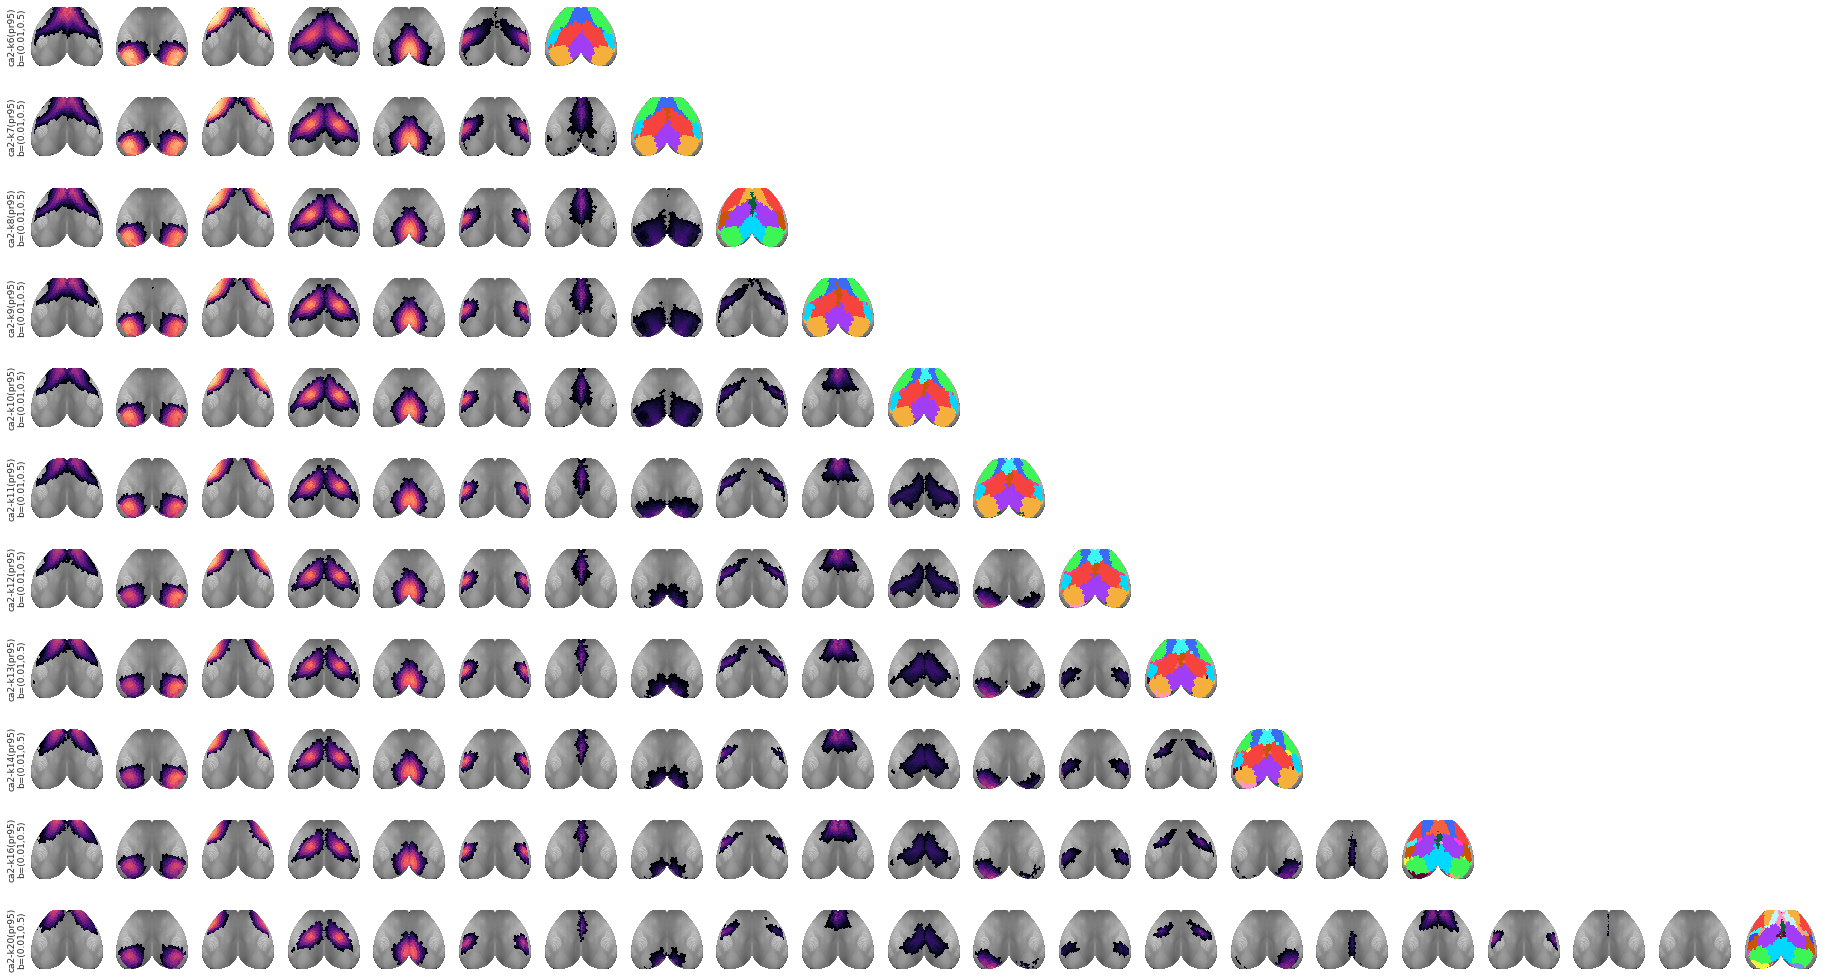

In [7]:
_ = gr_ca.show(d2p, figsize=(32, 18))

In [8]:
h_all = []
for kk, x in pi_all.items():
    h = sp_stats.entropy(bn.nanmean(x, -3), axis=-2) / np.log(x.shape[-2])
    h_all.append(np.expand_dims(h, 0))
h_all = np.concatenate(h_all)
h_avg = avg(h_all, 1, 1)

h_all.shape, h_avg.shape

((11, 10, 3, 4, 542), (11, 542))

In [9]:
np.nanmin(h_avg), np.nanmax(h_avg)

(0.01626300694224498, 0.6617088056791905)

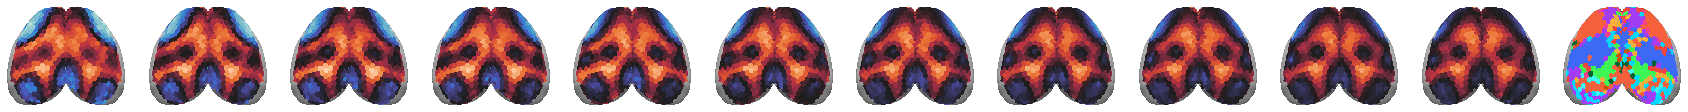

In [10]:
_ = gr_ca.show(
    h_avg,
    vmin=np.nanmin(h_avg),
    vmax=np.nanmax(h_avg),
    figsize=(30, 6),
    cmap='icefire',
)

In [11]:
sim_h = dist2sim(sp_dist.squareform(sp_dist.pdist(
    h_avg, metric='correlation')))

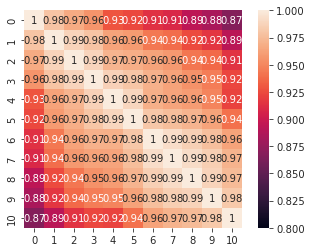

In [12]:
sns.heatmap(
    sim_h,
    vmin=0.8,
    vmax=1.0,
    square=True,
    annot=True,
    fmt='.2g',
)
plt.show()

### Ca2 (fast)

In [41]:
b = 0.5
mice.setup_func_data(task, band_ca=b)

In [42]:
%%time

pi_avg = {}
pi_all = {}
for kk in tqdm(list(range(6, 15)) + [16, 20]):
    props_ca['num_k'] = kk
    gr_ca = Group(**props_ca).fit_group()
    pi_ca = gr_ca.prune(thres=0.003, ci=0.95)['pi_prune']
    pi_all[kk] = pi_ca
    pi_avg[f'ca2-k{kk}(pr95)\nb={b}'.replace(' ', '')] = avg(pi_ca)
    
# sort
d2p = pi_avg.copy()
for i in range(len(pi_avg)):
    lbl, x = list(pi_avg.items())[i]
    if i == 0:
        continue
    src = list(d2p.values())[i - 1]
    gmap = find_best_mappings(
        centroids=src,
        data={0: x},
        match_metric='cosine',
        global_order='infer',
    )[0]
    ids = list(gmap.values())
    ids = ids + list(np.delete(range(len(x)), ids))
    d2p[lbl] = x[ids]

  0%|          | 0/11 [00:00<?, ?it/s]

CPU times: user 14h 1min 16s, sys: 22min 56s, total: 14h 24min 13s
Wall time: 24min 1s


In [43]:
gr_ca.fit_meta

{
    'time_start': '2022_06_07_13-23',
    'min_runs_thresh': 0.4099999999999998,
    'min_node_thresh': 0.4999999999999998,
    'best_node_freq_q': 0.885,
    'num_total_runs': 110,
    'fraction_accepted_runs': 0.41818181818181815,
    'fraction_good_nodes': 0.507380073800738,
    'time_end': '2022_06_07_13-28'
}

In [44]:
gr_ca.kw_kmeans

{'n_init': 100, 'max_iter': 300, 'tol': 0.0001}

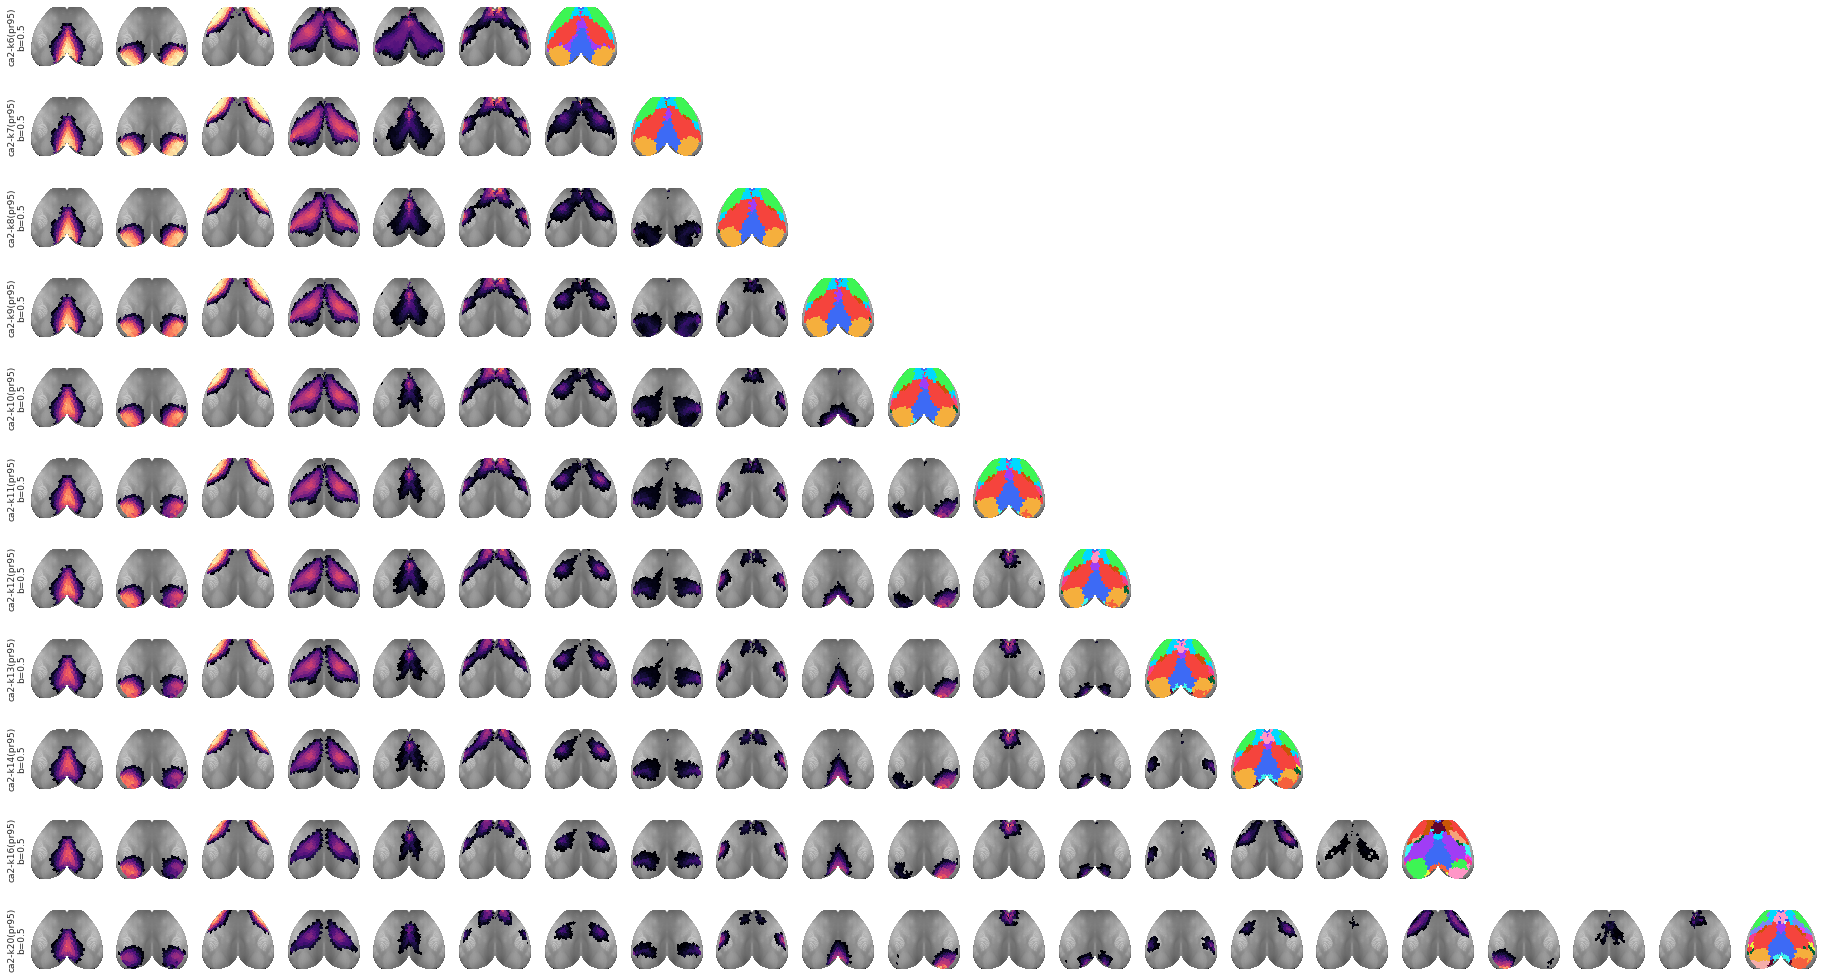

In [45]:
_ = gr_ca.show(d2p, figsize=(32, 18))

In [46]:
h_all = []
for kk, x in pi_all.items():
    h = sp_stats.entropy(bn.nanmean(x, -3), axis=-2) / np.log(x.shape[-2])
    h_all.append(np.expand_dims(h, 0))
h_all = np.concatenate(h_all)
h_avg = avg(h_all, 1, 1)

h_all.shape, h_avg.shape

((11, 10, 3, 4, 542), (11, 542))

In [47]:
np.nanmin(h_avg), np.nanmax(h_avg)

(0.0, 0.8548549272471334)

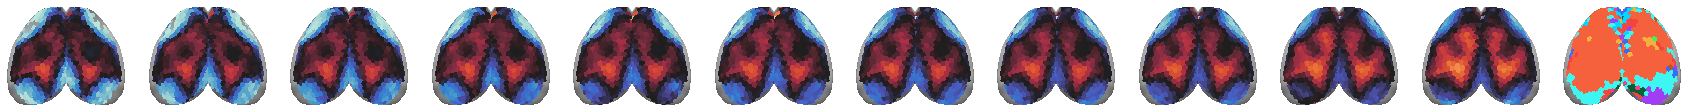

In [51]:
_ = gr_ca.show(
    h_avg,
    vmin=np.nanmin(h_avg) + 0.01,
    vmax=np.nanmax(h_avg),
    figsize=(30, 6),
    cmap='icefire',
)

In [52]:
sim_h = dist2sim(sp_dist.squareform(sp_dist.pdist(
    h_avg[:, np.isnan(h_avg).sum(0) == 0], metric='correlation')))

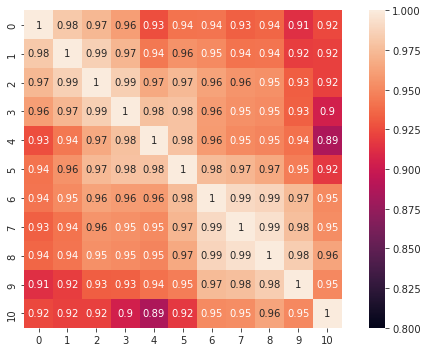

In [53]:
fig, ax = create_figure(1, 1, (8, 5))

sns.heatmap(
    sim_h,
    vmin=0.8,
    vmax=1.0,
    square=True,
    annot=True,
    fmt='.2g',
    ax=ax,
)
plt.show()

### Bold

In [23]:
%%time

pi_avg = {}
pi_all = {}
for kk in tqdm(list(range(6, 15)) + [16]):
    props_bo['num_k'] = kk
    gr_bo = Group(**props_bo).fit_group()
    pi_bo = gr_bo.prune(thres=0.003, ci=0.95)['pi_prune']
    pi_all[kk] = pi_bo
    pi_avg[f'bo-k{kk}(pr95)\nb={b}'.replace(' ', '')] = avg(pi_bo)
    
# sort
d2p = pi_avg.copy()
for i in range(len(pi_avg)):
    lbl, x = list(pi_avg.items())[i]
    if i == 0:
        continue
    src = list(d2p.values())[i - 1]
    gmap = find_best_mappings(
        centroids=src,
        data={0: x},
        match_metric='cosine',
        global_order='infer',
    )[0]
    ids = list(gmap.values())
    ids = ids + list(np.delete(range(len(x)), ids))
    d2p[lbl] = x[ids]

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 2d 16h 17min 20s, sys: 1h 50min 11s, total: 2d 18h 7min 32s
Wall time: 3h 10min 59s


In [24]:
gr_bo.fit_meta

{
    'time_start': '2022_06_06_18-39',
    'min_runs_thresh': 0.75,
    'min_node_thresh': 0.5799999999999997,
    'best_node_freq_q': 0.985,
    'num_total_runs': 114,
    'fraction_accepted_runs': 0.8245614035087719,
    'fraction_good_nodes': 0.584870848708487,
    'time_end': '2022_06_06_19-09'
}

In [25]:
gr_bo.kw_kmeans

{'n_init': 100, 'max_iter': 300, 'tol': 0.0001}

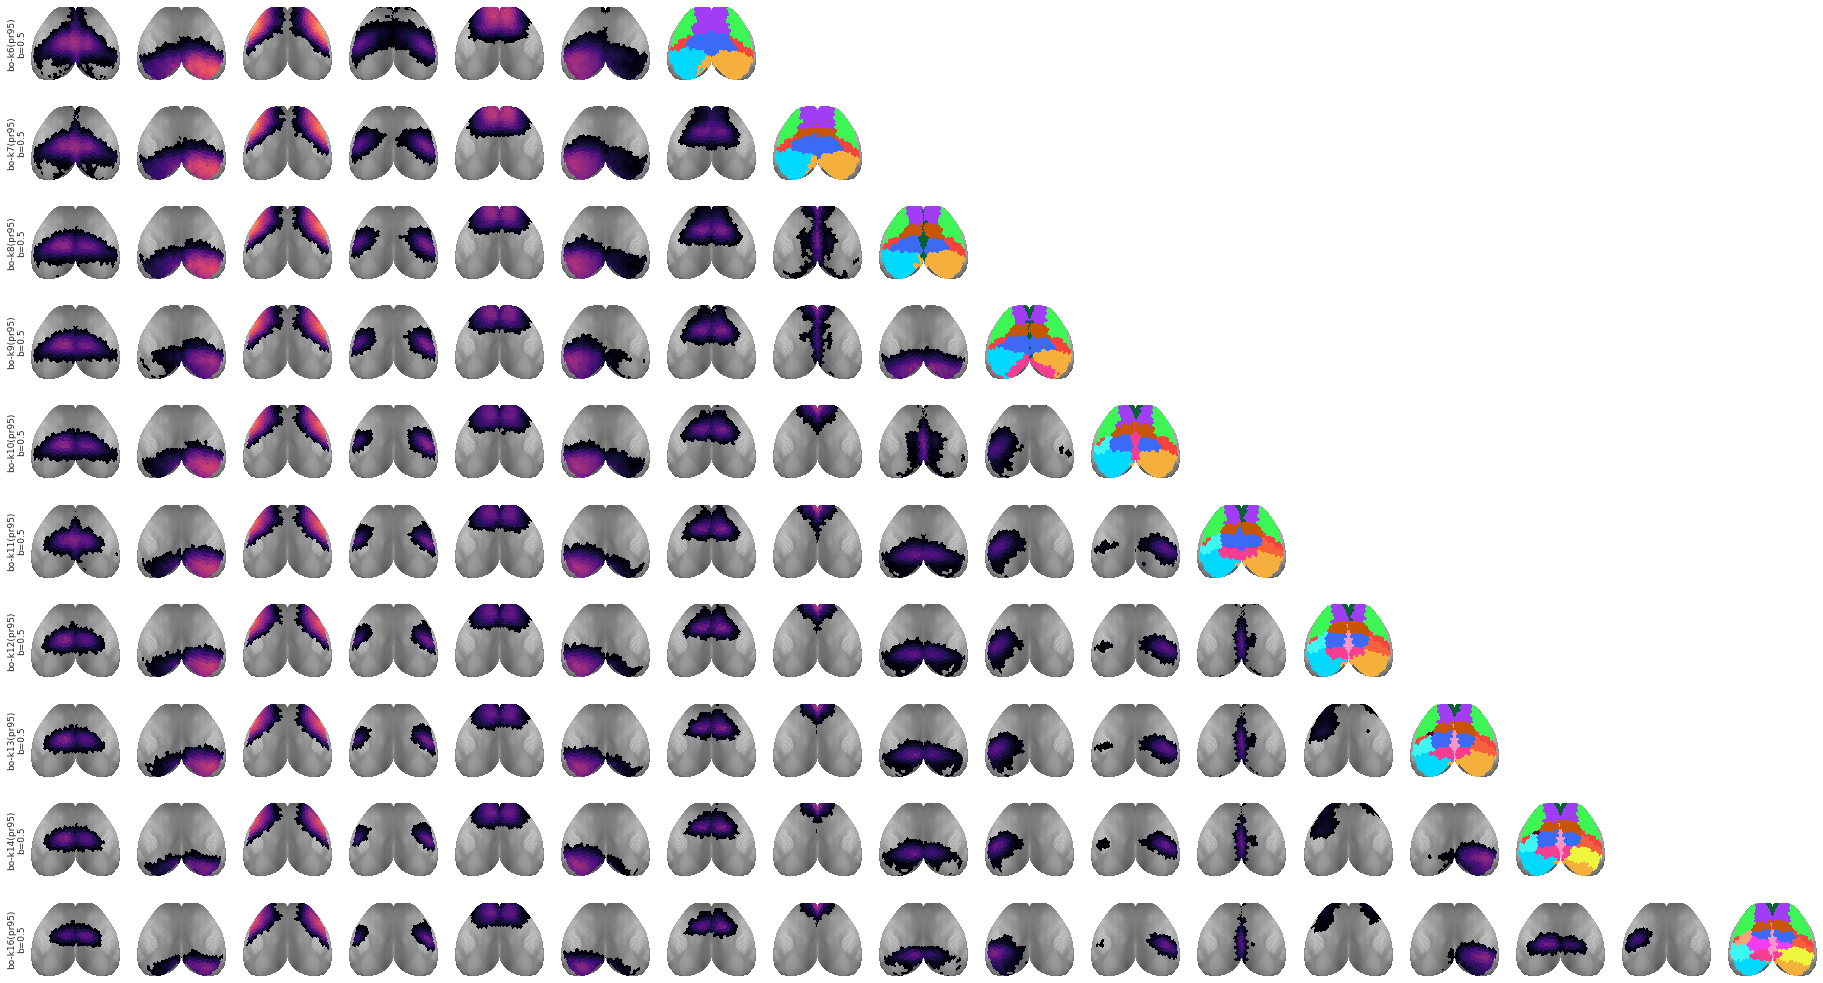

In [26]:
_ = gr_bo.show(d2p, figsize=(32, 18))

In [27]:
h_all = []
for kk, x in pi_all.items():
    h = sp_stats.entropy(bn.nanmean(x, -3), axis=-2) / np.log(x.shape[-2])
    h_all.append(np.expand_dims(h, 0))
h_all = np.concatenate(h_all)
h_avg = avg(h_all, 1, 1)

h_all.shape, h_avg.shape

((10, 10, 3, 4, 542), (10, 542))

In [28]:
np.nanmin(h_avg), np.nanmax(h_avg)

(0.3169394664604529, 0.7996287009554971)

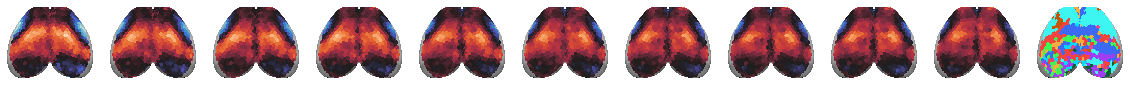

In [29]:
_ = gr_ca.show(
    h_avg,
    vmin=np.nanmin(h_avg),
    vmax=np.nanmax(h_avg),
    figsize=(20, 4),
    cmap='icefire',
)

In [30]:
sim_h = dist2sim(sp_dist.squareform(sp_dist.pdist(
    h_avg, metric='correlation')))

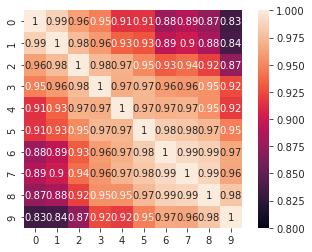

In [31]:
sns.heatmap(
    sim_h,
    vmin=0.8,
    vmax=1.0,
    square=True,
    annot=True,
    fmt='.2g',
)
plt.show()

### Bold (mg)

In [32]:
%%time

pi_avg = {}
pi_all = {}
for kk in tqdm(list(range(6, 15)) + [16]):
    props_bo['num_k'] = kk
    gr_bo = Group(**props_bo).fit_group()
    gr_bo.run_pi = gr_bo.prune(thres=0.003, ci=0.95)['pi_prune']
    gr_bo._merge_vis(0.1)
    
    pi_all[kk] = gr_bo.run_pi
    pi_avg[f'bo-k{kk-1}\n(pr95-mg1)\nb={b}'.replace(' ', '')] = avg(gr_bo.run_pi)
    
# sort
d2p = pi_avg.copy()
for i in range(len(pi_avg)):
    lbl, x = list(pi_avg.items())[i]
    if i == 0:
        continue
    src = list(d2p.values())[i - 1]
    gmap = find_best_mappings(
        centroids=src,
        data={0: x},
        match_metric='cosine',
        global_order='infer',
    )[0]
    ids = list(gmap.values())
    ids = ids + list(np.delete(range(len(x)), ids))
    d2p[lbl] = x[ids]

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 2d 15h 50min 56s, sys: 49min 33s, total: 2d 16h 40min 30s
Wall time: 1h 42min 54s


In [33]:
gr_bo.fit_meta

{
    'time_start': '2022_06_06_18-39',
    'min_runs_thresh': 0.75,
    'min_node_thresh': 0.5799999999999997,
    'best_node_freq_q': 0.985,
    'num_total_runs': 114,
    'fraction_accepted_runs': 0.8245614035087719,
    'fraction_good_nodes': 0.584870848708487,
    'time_end': '2022_06_06_19-09'
}

In [34]:
gr_ca.kw_kmeans

{'n_init': 100, 'max_iter': 300, 'tol': 0.0001}

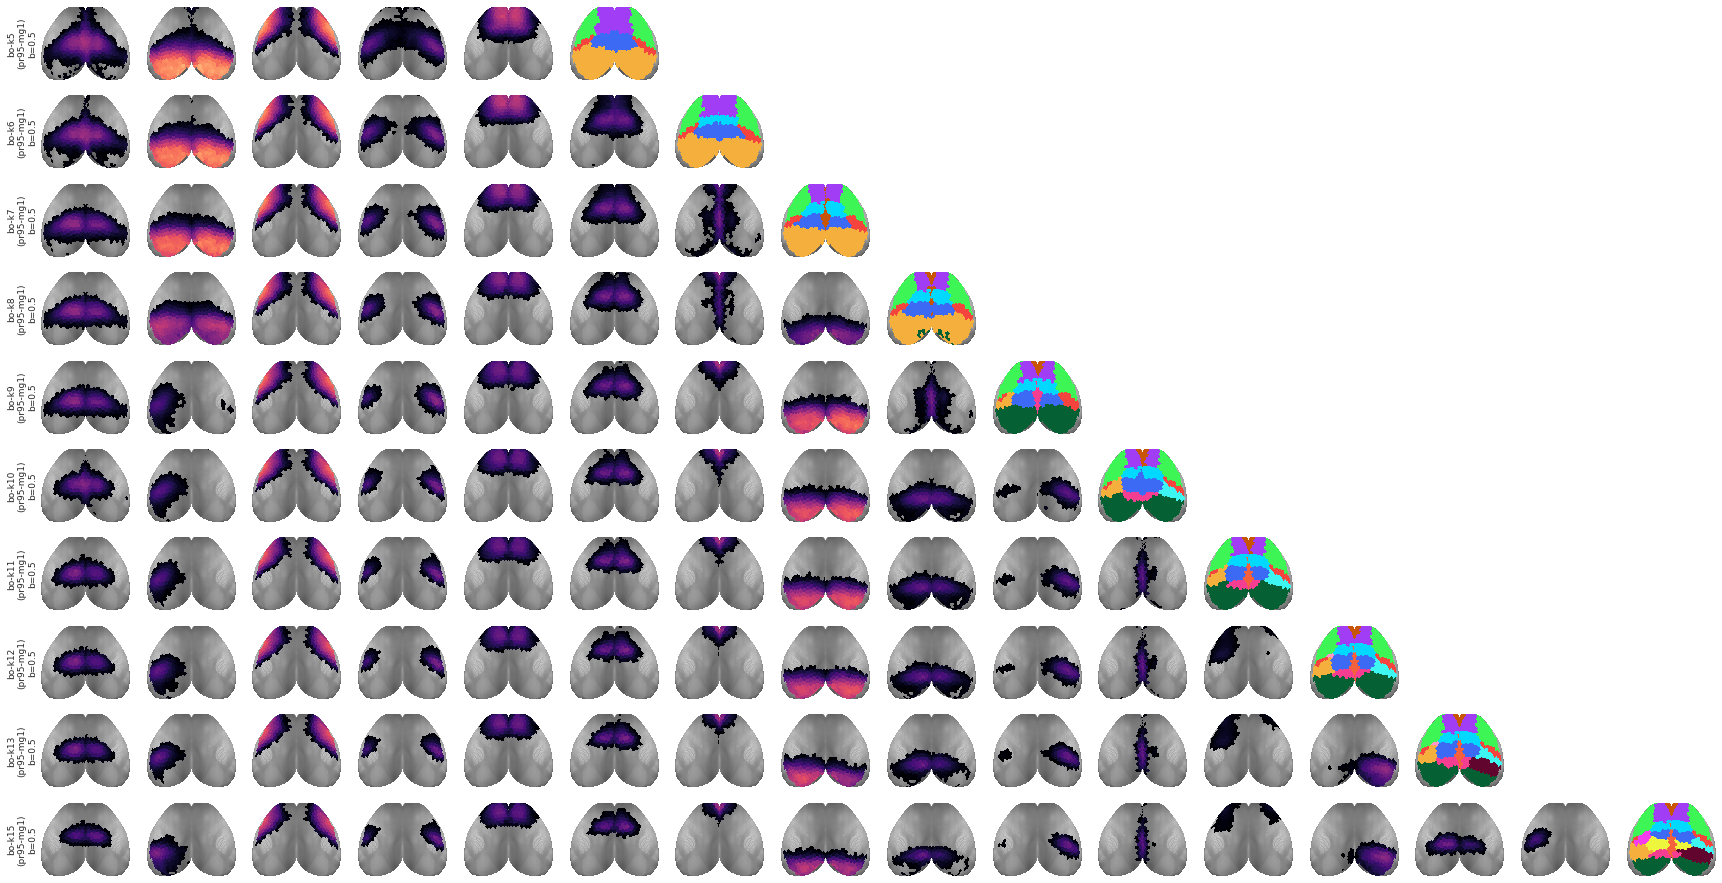

In [35]:
_ = gr_bo.show(d2p, figsize=(30, 16))

In [36]:
h_all = []
for kk, x in pi_all.items():
    h = sp_stats.entropy(bn.nanmean(x, -3), axis=-2) / np.log(x.shape[-2])
    h_all.append(np.expand_dims(h, 0))
h_all = np.concatenate(h_all)
h_avg = avg(h_all, 1, 1)

h_all.shape, h_avg.shape

((10, 10, 3, 4, 542), (10, 542))

In [37]:
np.nanmin(h_avg), np.nanmax(h_avg)

(0.2781593715899061, 0.8324238024583426)

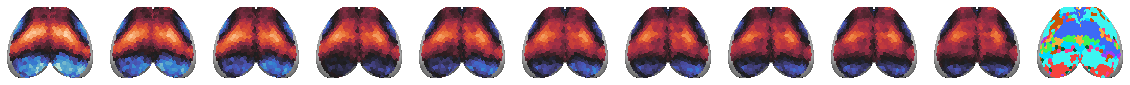

In [38]:
_ = gr_ca.show(
    h_avg,
    vmin=np.nanmin(h_avg),
    vmax=np.nanmax(h_avg),
    figsize=(20, 4),
    cmap='icefire',
)

In [39]:
sim_h = dist2sim(sp_dist.squareform(sp_dist.pdist(
    h_avg, metric='correlation')))

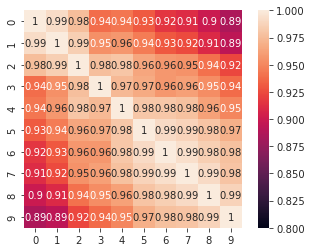

In [40]:
sns.heatmap(
    sim_h,
    vmin=0.8,
    vmax=1.0,
    square=True,
    annot=True,
    fmt='.2g',
)
plt.show()